# **R&D notebook for Implementing The Vision Transformer (ViT) paper.**

## *Section 0 - Setup Dependancies and Constants*

In [6]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torchinfo import summary
import os
import requests
import zipfile
from PIL import Image
from pathlib import Path
import tarfile
import random
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [7]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
IMG_SIZE = 224 # height and width of images 
CHANNELS = 3 # Number of channels in images 
BATCH_SIZE = 32 # Number of samples in each Batach
PATCH_SIZE = 16 # height and width of image patches 
FF_D = 3072 # feed forward dimension  
D = 768 # embedding dimension 
NUM_HEADS = 12 # number of encoder heads 
NUM_LAYERS = 12 # number of encoder layers
DROPOUT = 0.1 # dropout ratio 
EPOCHS = 20 # number of training epochs
LR = 1e-3 # learning rate
BETAS = (0.9, 0.999) # betas for Adam optimizer
WEIGHT_DECAY = 0.01 # weight decay
WARMUP_STEPS = 1000 # warmup steps
NUM_WORKERS = os.cpu_count()

In [9]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## *Section 1 - Get the data*

In this notebook, I use CIFER10 DATASET to train the VIT.
Normally, it's more convenient to use larger datasets with hundreds of millions or billions of images to get the best performance of ViT over the normal CNNs. 
But I use this dataset due to resource limitations only.  

In [10]:
def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source=link to the dataset download,
                      destination="dataset")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download the data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        if target_file.endswith(".zip"):
            # Unzip the data
            with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
                print(f"[INFO] Unzipping {target_file} data...") 
                zip_ref.extractall(image_path)
        
        elif target_file.endswith(".tar"):
            with tarfile.open(data_path / target_file, "r") as tar:
                tar.extractall(image_path)

        elif target_file.endswith(".gz"):
            with tarfile.open(data_path / target_file, "r:gz") as tar:
                tar.extractall(image_path)
        
        else:
            raise TypeError("Invalid type provided!")

        # Remove file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


In [11]:
data_path = download_data(source="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
                           destination="CIFAR10")
data_path

[INFO] data/CIFAR10 directory exists, skipping download.


PosixPath('data/CIFAR10')

In [12]:
data_path = Path('./data/CIFAR10')

## *Section 2 - Create Dataset*

In this section I create a custom dataset class to get use of the dataset and load it into dataloaders. 

In [13]:
class CIFAR10Custom(Dataset):
    def __init__(self, data_dir: str, train: bool = True, transform=None) -> None:
        """
        Custom Dataset for CIFAR-10.

        Args:
            data_dir (str): Path to the extracted CIFAR-10 dataset directory (e.g., 'cifar-10-batches-py').
            train (bool): If True, loads training data; otherwise, loads test data.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get file names
        if train:
            batch_files = [i for i in os.listdir(self.data_dir) if i.startswith("data_batch")] 
        else:
            batch_files = ['test_batch']

        self.images, self.labels = self._load_batches(batch_files)

        # CIFAR-10 class labels
        self.classes = [
            'airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def _load_batches(self, batch_files):
        """Loads data from CIFAR-10 binary files."""
        all_images, all_labels = [], []
        for batch_file in batch_files:
            batch_path = os.path.join(self.data_dir, batch_file)
            with open(batch_path, 'rb') as f:
                batch_dict = pickle.load(f, encoding='latin1') 
                images = batch_dict['data']
                labels = batch_dict['labels']

                # Reshape images (num_samples, 3, 32, 32) -> (num_samples, 32, 32, 3)
                images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
                
                all_images.append(images)
                all_labels.extend(labels)
        
        return np.concatenate(all_images), np.array(all_labels)

    def load_image(self, index: int) -> Image.Image:
        """Opens an image from the dataset and returns it as a PIL Image."""
        return Image.fromarray(self.images[index])

    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.images)

    def __getitem__(self, index) -> tuple:
        """Returns one sample of data: (image, label)."""
        img = self.load_image(index)
        #img = self.images[index]
        label = self.labels[index]

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label


In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Created Transforms: {train_transforms}')

Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


In [15]:
train_dataset = CIFAR10Custom(data_dir=data_path, train=True, transform=train_transforms)
test_dataset = CIFAR10Custom(data_dir=data_path, train=False, transform=test_transforms)

In [16]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

class_names = train_dataset.classes

In [17]:
len(train_dataloader), len(test_dataloader), class_names

(1563,
 313,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

#### *Visualize images*

In [18]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool =True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f'For display purposes, n shouldn\'t be larger than 10, setting to 10 and removing shape_display.')

    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16,8))


    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample]
        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

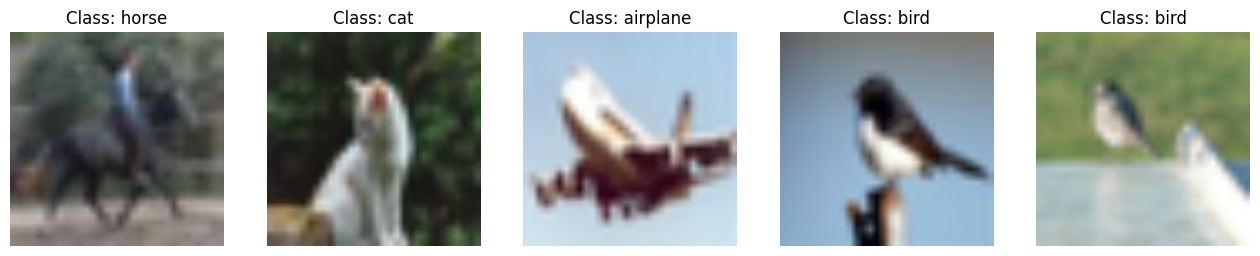

In [19]:
display_random_images(dataset=train_dataset, classes=class_names, n=5, display_shape=False)

In [20]:
arb_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=1,
                            shuffle=False,)

In [21]:
batch = next(iter(arb_dataloader))

image, label = batch[0][0], batch[1][0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(6))

(-0.5, 223.5, 223.5, -0.5)

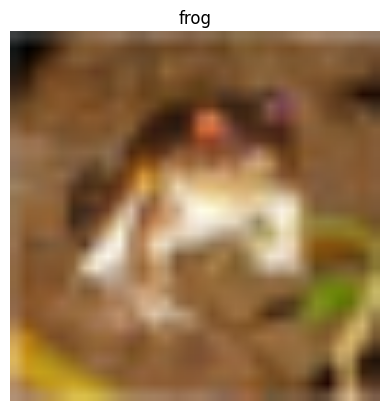

In [22]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## *Section 3 - Building ViT model*

### ViT overview

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 


**Figure 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.


### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>


**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```
---

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 



### Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


*Visualizing how to patch an image sample*

In [23]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [24]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


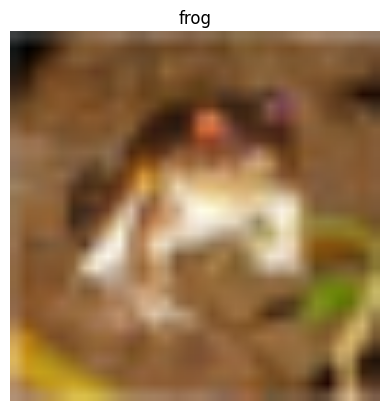

In [25]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

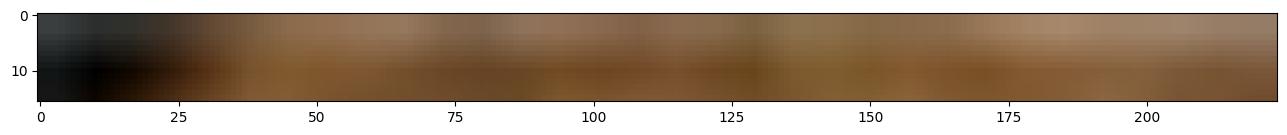

In [26]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


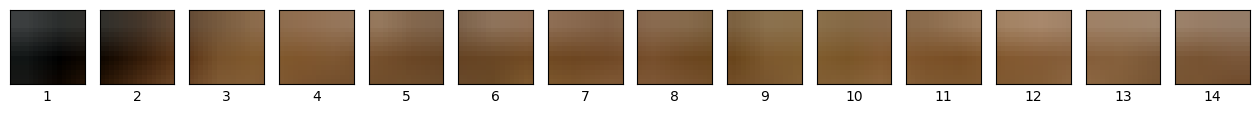

In [27]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


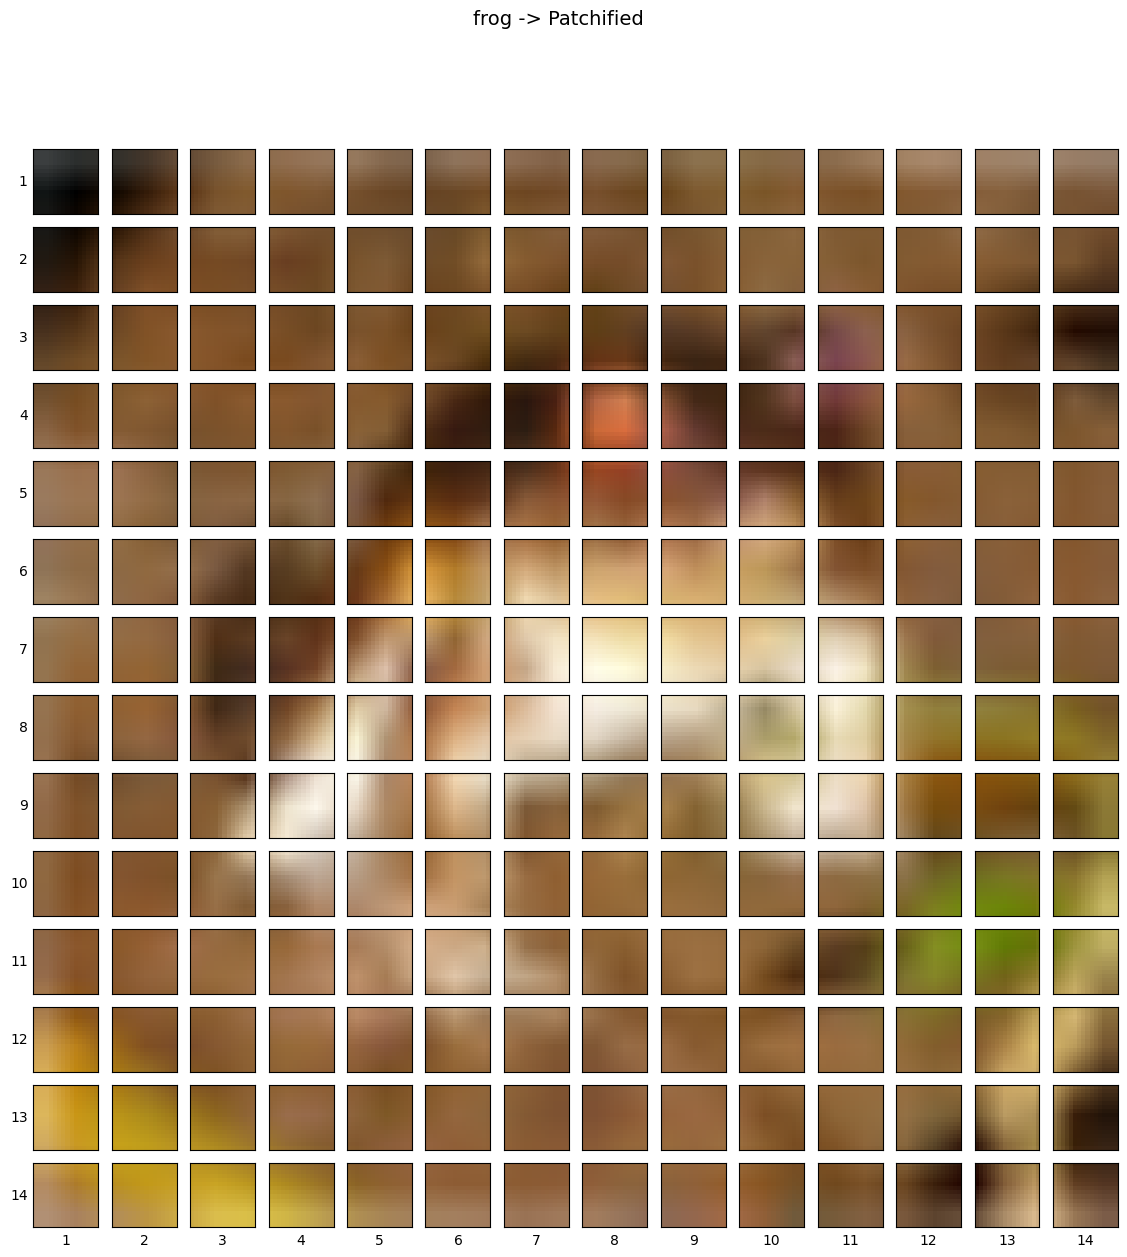

In [28]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

In [29]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=PATCH_SIZE,
                   stride=PATCH_SIZE,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [30]:
embedded_image = conv2d(image.unsqueeze(0)) # Add batch dimension
embedded_image.shape

torch.Size([1, 768, 14, 14])

In [31]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flattened = flatten_layer(embedded_image)
flattened.shape

torch.Size([1, 768, 196])

In [32]:
# Rearrange output of flattened layer
flattened_permuted = flattened.permute(0, 2, 1)
print(f"{flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


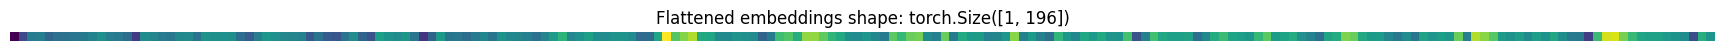

In [33]:
# Get a single flattened feature map
single_flattened_embeddings = flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_embeddings.detach().numpy())
plt.title(f"Flattened embeddings shape: {single_flattened_embeddings.shape}")
plt.axis(False); 

In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embed_dim:int=768, img_size:int=224) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embed_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(torch.randn(1,1,embed_dim), requires_grad=True)

        self.position_embedding = nn.Parameter(torch.randn(1,self.num_patches+1, embed_dim), requires_grad=True)


    def forward(self, x):
        batch_size, image_res = x.shape[0], x.shape[-1]
        assert image_res % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_res}, patch_size: {self.patch_size}"
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patcher(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x

        return x


In [35]:
set_seeds()

patchify = PatchEmbedding()

print(f'Input image size: {image.unsqueeze(0).shape}')

patch_embedded_image = patchify(image.unsqueeze(0))

print(f'Output patch embedding sequance shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequance shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension. 
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [36]:
class MultiHeadSelfAttention(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    def __init__(self, embed_dim: int=768, num_heads:int=12, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.size()
        
        x = self.layer_norm(x)

        # Linear projection to obtain queries, keys, and values
        qkv = self.qkv_proj(x)  # (batch_size, seq_length, 3 * embed_dim)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1)  # (num_heads, batch_size, 3 * head_dim, seq_length)
        queries, keys, values = torch.chunk(qkv, 3, dim=2)  # Each is (num_heads, batch_size, head_dim, seq_length)
        
        # Scaled dot-product attention
        scores = torch.matmul(queries.transpose(-2, -1), keys) / (self.head_dim ** 0.5)  # (num_heads, batch_size, seq_length, seq_length)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        
        attn_weights = torch.softmax(scores, dim=-1)  # (num_heads, batch_size, seq_length, seq_length)
        attn_weights = self.dropout(attn_weights)
        
        attn_output = torch.matmul(attn_weights, values.transpose(-2, -1))  # (num_heads, batch_size, seq_length, head_dim)
        attn_output = attn_output.permute(1, 2, 0, 3).contiguous()  # (batch_size, seq_length, num_heads, head_dim)
        attn_output = attn_output.view(batch_size, seq_length, self.embed_dim)  # (batch_size, seq_length, embed_dim)
        
        output = self.o_proj(attn_output)  # (batch_size, seq_length, embed_dim)
        
        return output


In [37]:
class MultiHeadSelfAttention_builtin(nn.Module): 
  """Creates a multi-head self-attention block ("MSA block" for short)."""
  def __init__(self, embed_dim:int=768, num_heads:int=12, dropout:float=0.0):
    super().__init__()
    
    self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim,
                                                num_heads=num_heads,
                                                dropout=dropout, 
                                                batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embed_dimension)
  
  def forward(self, x):
    x = self.layer_norm(x)
    output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return output

In [43]:
multihead_self_attention_block = MultiHeadSelfAttention()
attention_image = multihead_self_attention_block(patch_embedded_image)
print(f"Input shape of MSA block: {patch_embedded_image.shape}")
print(f"Output shape of MSA block: {attention_image.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


### Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer. 
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. 
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU 
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts. 
  * Value for Dropout available in Table 3 

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [44]:
class MLPBlock(nn.Module):
  def __init__(self, embed_dim:int=768, ff_dim:int=3072, dropout:float=0.1):
    super().__init__()
    
    self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embed_dim,
                  out_features=ff_dim),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=ff_dim,
                  out_features=embed_dim),
        nn.Dropout(p=dropout) 
    )
  
  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [45]:
mlp_block = MLPBlock()
mlp_image = mlp_block(attention_image)
print(f"Input shape of MLP block: {attention_image.shape}")
print(f"Output shape of MLP block: {mlp_image.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


### Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ... 
```

In [49]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim:int=768, num_heads:int=12, ff_dim:int=3072, dropout:float=0.1, atten_dropout:float=0.0)->None:
        super().__init__()

        self.msa = MultiHeadSelfAttention(embed_dim=embed_dim,
                                                   num_heads=num_heads,
                                                   dropout=atten_dropout)
        
        self.mlp = MLPBlock(embed_dim=embed_dim,
                            ff_dim=ff_dim,
                            dropout=dropout)
        
    
    def forward(self, x):
        x = self.msa(x) + x
        x = self.mlp(x) + x
        return x


In [50]:
transformerencoderblock = TransformerEncoderBlock()

summary(model=transformerencoderblock,
        input_size=(1,197,768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttention (msa)                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Linear (qkv_proj)                           [1, 197, 768]        [1, 197, 2304]       1,771,776            True
│    └─Dropout (dropout)                           [12, 1, 197, 197]    [12, 1, 197, 197]    --                   --
│    └─Linear (o_proj)                             [1, 197, 768]        [1, 197, 768]        590,592              True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                

In [51]:
builtin_transformerencoder = nn.TransformerEncoderLayer(d_model=D,
                                                        nhead=NUM_HEADS,
                                                        dim_feedforward=FF_D,
                                                        dropout=0.1,
                                                        activation='gelu',
                                                        batch_first=True,
                                                        norm_first=True)

summary(model=builtin_transformerencoder,
        input_size=(1,197,768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [52]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_encoder_layers:int=12,
                 embed_dim:int=768,
                 ff_dim:int=3072,
                 num_heads:int=12,
                 dropout:float=0.1,
                 atten_dropout:float=0.0,
                 num_classes:int=10) -> None:
        """
        Vision Transformer model. a.k.a. ViT.
        
        Args:
            img_size (int): Image size (assuming square image).
            in_channels (int): Number of input channels.
            patch_size (int): Patch size.
            num_encoder_layers (int): Number of encoder layers.
            embed_dim (int): Embedding dimension.
            ff_dim (int): Feedforward dimension.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout rate.
            atten_dropout (float): Attention dropout rate.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        
        assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        self.embedding_dropout = nn.Dropout(p=dropout)

        self.patch_embed = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embed_dim=embed_dim,
                                          img_size=img_size)
        
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(embed_dim=embed_dim,
                                    num_heads=num_heads,
                                    ff_dim=ff_dim,
                                    dropout=dropout,
                                    atten_dropout=atten_dropout) for _ in range(num_encoder_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.embedding_dropout(x)
        x = self.encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [53]:
summary(model=VisionTransformer(),
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)         [1, 3, 224, 224]     [1, 10]              --                   True
├─PatchEmbedding (patch_embed)                [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                 [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (encoder)                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─MultiHeadSelfAttention (msa)      [1, 197, 768]        [1, 197, 768]       

## *Section 4 - Training the model*


In [54]:
vit = VisionTransformer(img_size=IMG_SIZE,
                        in_channels=CHANNELS,
                        patch_size=PATCH_SIZE,
                        num_encoder_layers=NUM_LAYERS,
                        embed_dim=D,
                        ff_dim=FF_D,
                        num_heads=NUM_HEADS,
                        dropout=DROPOUT,
                        atten_dropout=0.0,
                        num_classes=10)

In [55]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=LR,
                             betas=BETAS,
                             weight_decay=WEIGHT_DECAY)

loss_fn = torch.nn.CrossEntropyLoss()

In [56]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(dataloader):
        
        X,y = X.to(device), y.to(device)

        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [57]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate (dataloader):
            X,y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits,dim=1), dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [58]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                         dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)
        
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.4f} | Training Accuarcy: {train_acc:.2f}\nTest Loss: {test_loss:.4f} | Test Accuarcy: {test_acc:.2f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [59]:
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 2.1930 | Training Accuarcy: 0.17
Test Loss: 2.1079 | Test Accuarcy: 0.17
Epoch: 1 | Training Loss: 2.1112 | Training Accuarcy: 0.19
Test Loss: 2.1345 | Test Accuarcy: 0.18
Epoch: 2 | Training Loss: 2.0555 | Training Accuarcy: 0.21
Test Loss: 1.9961 | Test Accuarcy: 0.23
Epoch: 3 | Training Loss: 1.9811 | Training Accuarcy: 0.24
Test Loss: 1.9511 | Test Accuarcy: 0.24
Epoch: 4 | Training Loss: 1.9655 | Training Accuarcy: 0.24
Test Loss: 1.9775 | Test Accuarcy: 0.23
Epoch: 5 | Training Loss: 1.9601 | Training Accuarcy: 0.24
Test Loss: 1.9329 | Test Accuarcy: 0.25
Epoch: 6 | Training Loss: 1.9560 | Training Accuarcy: 0.24
Test Loss: 1.9688 | Test Accuarcy: 0.24
Epoch: 7 | Training Loss: 1.9513 | Training Accuarcy: 0.25
Test Loss: 1.9311 | Test Accuarcy: 0.25
Epoch: 8 | Training Loss: 1.9496 | Training Accuarcy: 0.25
Test Loss: 1.9232 | Test Accuarcy: 0.25
Epoch: 9 | Training Loss: 1.9499 | Training Accuarcy: 0.24
Test Loss: 1.9452 | Test Accuarcy: 0.25
Epoch: 10 

In [59]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

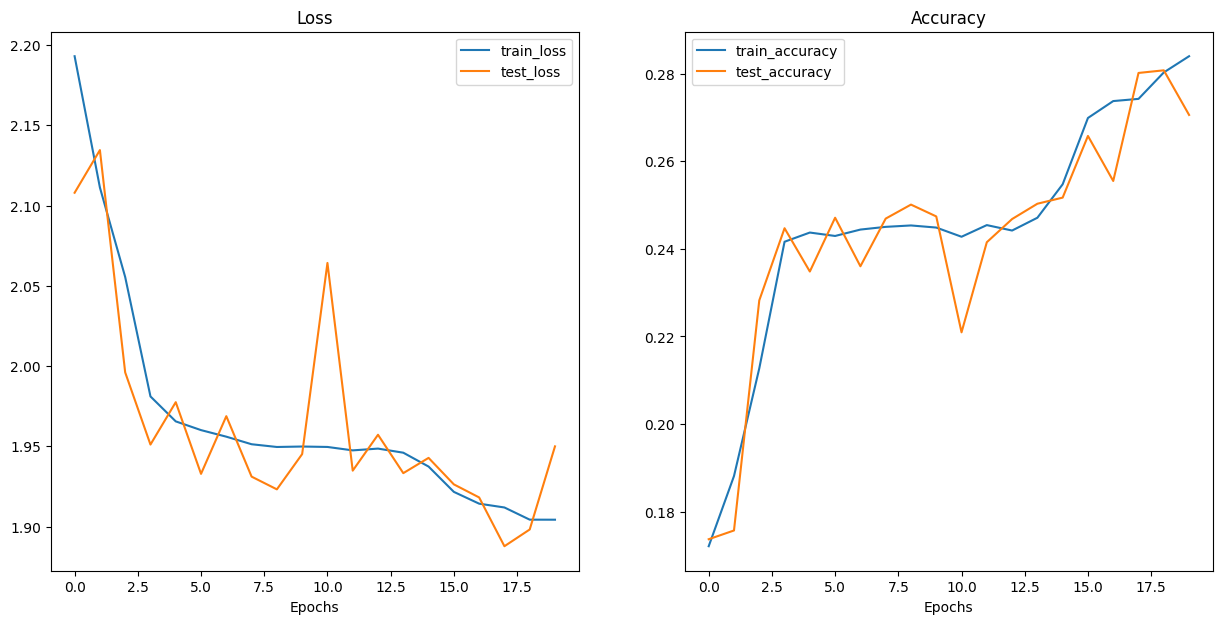

In [61]:
plot_loss_curves(results=results)

In [60]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str) -> None:
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="model_2.pth")
    """

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth' "
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")

    torch.save(obj=model.state_dict(), f=model_save_path)

In [63]:
save_model(model=vit,
            target_dir="models",
            model_name="vit_cifar10.pth")

[INFO] Saving model to: models/vit_cifar10.pth


In [61]:
def load_model(model: torch.nn.Module, model_path: str) -> torch.nn.Module:
    """Loads a PyTorch model from a given file path.

    Args:
        model: A PyTorch model instance (should be the same architecture as the saved model).
        model_path: Path to the saved model file (".pth" or ".pt").

    Returns:
        The PyTorch model with loaded weights.

    Example usage:
        model = YourModelClass()  # Initialize the model architecture
        model = load_model(model, "models/model_2.pth")
    """
    model_path = Path(model_path)
    
    assert model_path.exists(), f"Model file not found: {model_path}"
    
    print(f"[INFO] Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path))
    
    return model

In [62]:
load_model(model=vit,model_path='./models/vit_cifar10.pth')

[INFO] Loading model from: models/vit_cifar10.pth


VisionTransformer(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embed): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (mlp): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
       

In [66]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # target_image = target_image / 255.0
    target_image = Image.open(image_path)

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
     
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


In [67]:
custom_image_path = 'images.jpg'

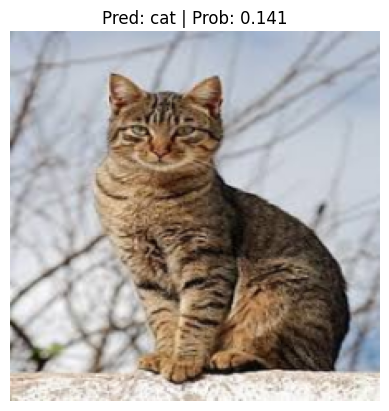

In [68]:
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names,
                   transform=test_transforms)

## *Section 5 - Finetune a pretrained model*


In [69]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [70]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 10]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [71]:
# Get automtic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [72]:
train_dataset_pretrained = CIFAR10Custom(data_dir=data_path, train=True, transform=vit_transforms)
test_dataset_pretrained = CIFAR10Custom(data_dir=data_path, train=False, transform=vit_transforms)

In [73]:
train_dataloader_pretrained = DataLoader(dataset=train_dataset_pretrained,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_pretrained = DataLoader(dataset=test_dataset_pretrained,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

class_names = train_dataset.classes

In [74]:
optimizer_pre = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn_pre = torch.nn.CrossEntropyLoss()

In [75]:
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_pre,
                                      loss_fn=loss_fn_pre,
                                      epochs=2,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 0.2153 | Training Accuarcy: 0.93
Test Loss: 0.1666 | Test Accuarcy: 0.95


KeyboardInterrupt: 

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
save_model(model=pretrained_vit,
            target_dir="models",
            model_name="pretrained_vit_cifar10.pth")

In [ ]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)